### <u><i>Walmart Weekly Sales Forecasting 

### Aim
The goal of this project is to develop a model that can forecast store sales based on past sales patterns.<br> With this model, decision-makers can make critical business decisions, maximize revenue, and improve sales in underperforming departments.

In [1]:
## Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_squared_error
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

C:\Users\ADMIN\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("Walmart DataSet.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


**Column Description**
- Store : Store Number
- Date : Weekly Dates
- Weekly Sales : Weekly Sales of that perticular store for the mentioned week
- Holiday Flag: Haliday in that week 
- Temperature : Average Temperature for the respective week
- Fure Price : Average Fule Price for the respective week
- CPI : Consumer Price Index. Measures changes in the price level of a basket of consumer goods and services purchased by households
- Unemployment Rate : Unemployment Rate in the store area

### Explolatory Data Analysis

In [3]:
## Shape of data
df.shape

(6435, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
## Statistical summary of the Dataset
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [6]:
## Checking for Nulls
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [7]:
## Checking for duplicates 
df[df.duplicated()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


In [8]:
## Total number of stores
df.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

- We have total 45 individual stores 

**Outliers** can have a significance inportance here in retail setup. It can be because of some advertisement, publicity, holiday season, or Marketing Strategy outcome. Threfore keeping the outliers.

In [9]:
## Changing "Date" datatype to datetime
df["Date"] = pd.to_datetime(df["Date"],dayfirst=True)

In [10]:
## Checking for Correlation of All features with Weekly_Sales
df.corr(numeric_only=True)["Weekly_Sales"]

Store          -0.335332
Weekly_Sales    1.000000
Holiday_Flag    0.036891
Temperature    -0.063810
Fuel_Price      0.009464
CPI            -0.072634
Unemployment   -0.106176
Name: Weekly_Sales, dtype: float64

In [11]:
## Checking for correlation in Weekly sales and other parameters 
df.corr(numeric_only=True)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000


### Data Visualization

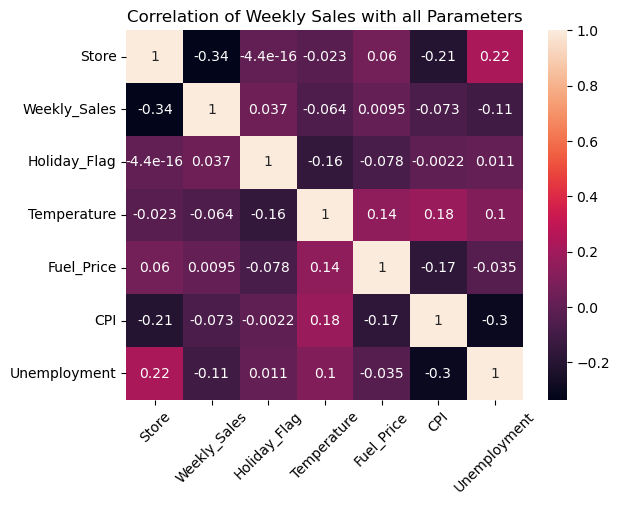

In [12]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.xticks(rotation = 45)
plt.title("Correlation of Weekly Sales with all Parameters")
plt.show()

**Observations:**
- Holidays, Temperature, Fuel Price and CPI have very weak correlation with Weekly_Sales.
- Unemploymet has weak negative correlation with Weekly Sales

Text(0.5, 1.0, 'Histogram of Continuous Values')

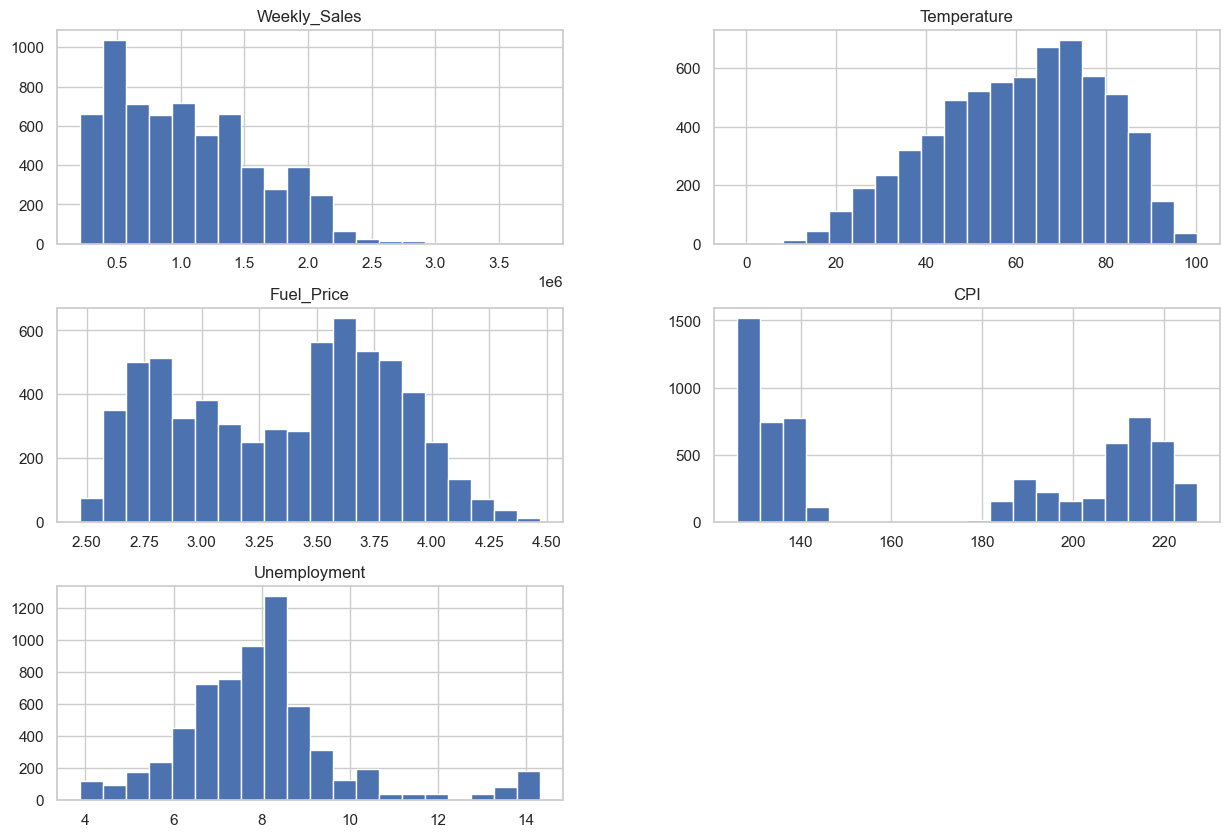

In [13]:
## Checking distribution of Continuous features

continuous_features = ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]

sns.set(style="whitegrid")
df[continuous_features].hist(bins=20, figsize=(15,10))
plt.title("Histogram of Continuous Values")

- Maximum numbers of stores having weekly sales around 500k per week 
- Most of the stores have weekly sales in the range of 500k to 1.5M 

<Axes: >

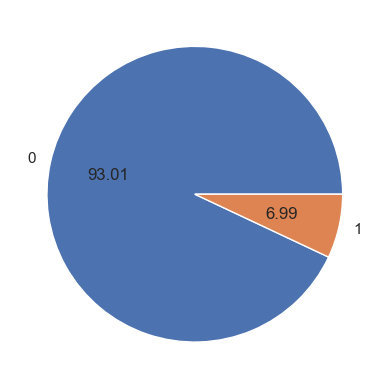

In [14]:
## Checking for the Holidays
df.groupby("Holiday_Flag").size().plot(kind="pie", autopct="%.2f")

- 93% of the time there was no holiday. 
- only 7% of the time weeks include holiday

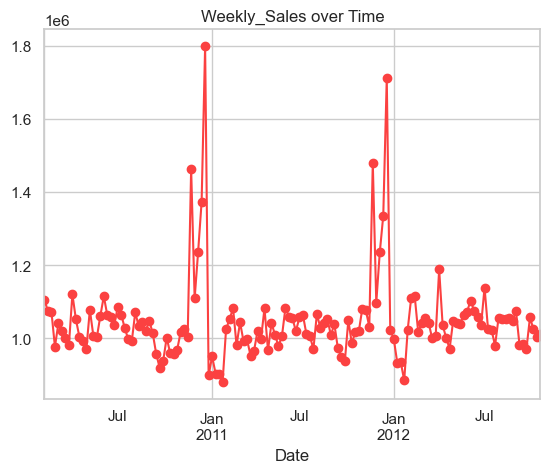

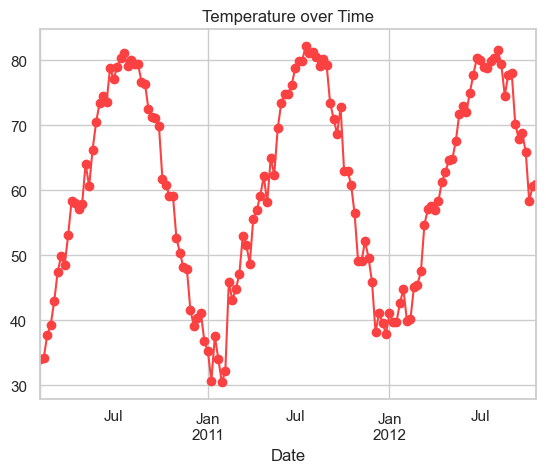

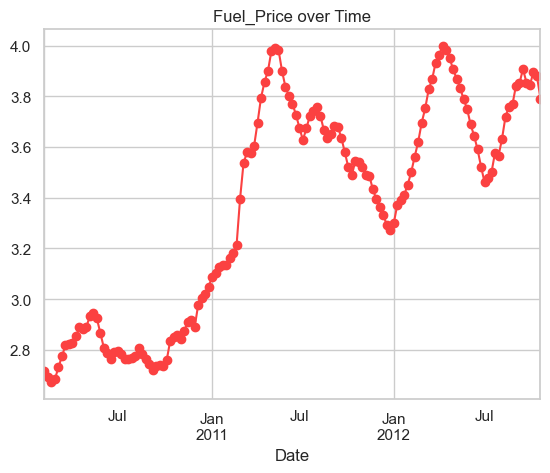

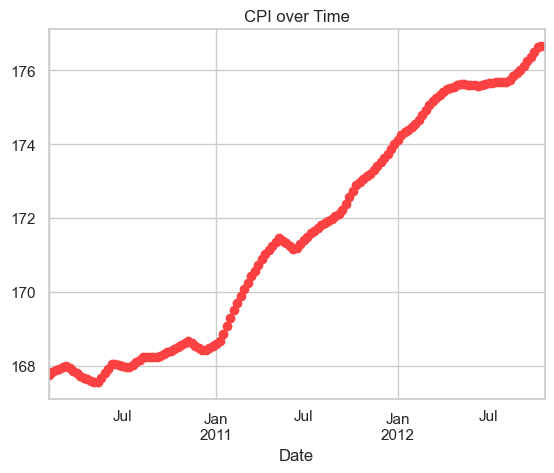

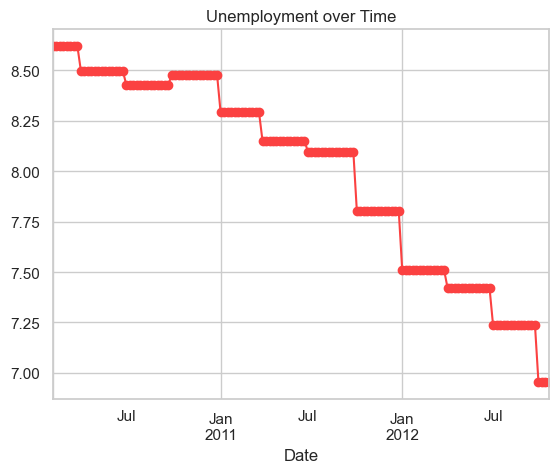

In [15]:
## Checking for effects on Continues features over time

for feature in continuous_features:
    df.groupby("Date")[feature].mean().plot(marker="o", linestyle="-", color='#FB4141')
    plt.title(f"{feature} over Time")
    plt.show()

***Observations:***
- There is high sales during the period of November to January. As it's peak Holiday period. 
- Temperature is high around the month of July and very low at the time of ear end, December and January.
- Fuel Price has been increased over the time
- Consumer Price index has been increase over the time which indicats the increase in Inflation. The cost of living has increasing with time
- Unemployment has been decrease over the time in the stores location/area. 

In [16]:
## Top performing stores according to the historical data

top_performing_stores = pd.DataFrame(df.groupby("Store")["Weekly_Sales"].sum().sort_values(ascending=False).head())
top_performing_stores

,Weekly_Sales
Store,
20,3.013978e+08
4,2.995440e+08
14,2.889999e+08
13,2.865177e+08
2,2.753824e+08


In [17]:
## Worst performing stores according to the historical data
worst_performing_stores=pd.DataFrame(df.groupby("Store")["Weekly_Sales"].sum().sort_values(ascending=True).head())
worst_performing_stores

,Weekly_Sales
Store,
33,37160221.96
44,43293087.84
5,45475688.90
36,53412214.97
38,55159626.42


In [18]:
##  How significant is the difference between the highest and lowest performing stores
significant_diff = top_performing_stores.iloc[0] - worst_performing_stores.iloc[0]
print(f"The Significance difference between Top and Worst performing Stores is {significant_diff[0]:.2f}/-")

The Significance difference between Top and Worst performing Stores is 264237570.50/-


In [19]:
## Creating individual store subsets
df_stores = {}

for store in df["Store"].unique():
    df_stores["store"+str(store)] = df[df["Store"] == store][["Date", "Weekly_Sales"]].set_index("Date")
    
for store, dataframe in df_stores.items():
    globals()[store] = dataframe
    

In [20]:
store1

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


### Forcasting model Building

#### Choosing the right model
We are going to use ARIMA, SARIMAX and Prophet model and choose the best among them for further forecasting

#### Creating Methods for repeatative functionalities

In [21]:
### Method for checking Stationarity using Augmented Dickey-Fuller Test

def adf_test(data):
    values = adfuller(data)
    keys = ["Test_Statistic","P_value","#Lags","#Observations","Critical Value","AIC"]
    
    return [f"{key} : {value}" for key,value in zip(keys,values)]
        

In [22]:
### Method for Seasonal Decomposition
def seasonal_decomp(data):
    decomp = seasonal_decompose(data, model="additive", period = 52) # since seasonal period repeat after  year
    return decomp.plot()

In [23]:
### Method for checking the ACF and PACF for Moving average(p) and Autoregressor(q)

def acf_pacf(data):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    plot_acf(data, lags=20, ax=axes[0])
    plot_pacf(data, lags=20, ax=axes[1])
    plt.show()

#### Will try wich model fits best for this data for Store1 data and will use the best fit for rest forecasting

### * Best Fit Model Testing

In [26]:
## Checking for Stationarity using statistical method of Store1
adf_test(store1)

['Test_Statistic : -5.102186145192288',
 'P_value : 1.3877788330759434e-05',
 '#Lags : 4',
 '#Observations : 138',
 "Critical Value : {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}",
 'AIC : 3412.7325502876756']

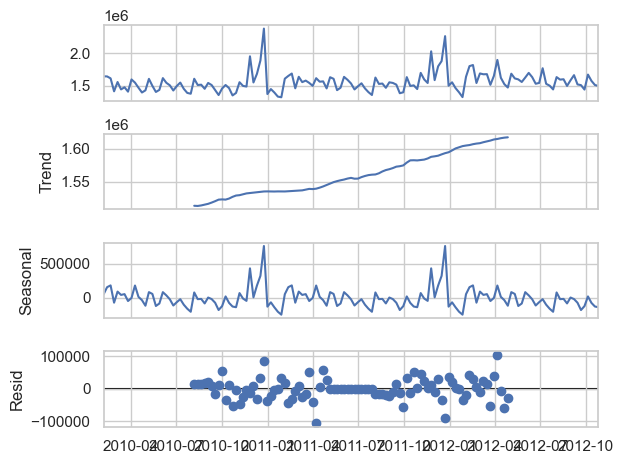

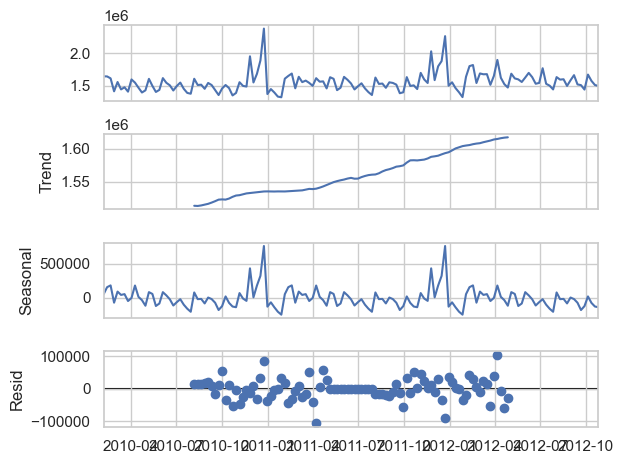

In [27]:
## Chcking seasonal decomposition
seasonal_decomp(store1)

***For statistical test the p-value < 0.05 but in seasonal decomposition we can see a visible trend.***

In [28]:
## Performing differentiation to reduce the trend
stationary_store1 = store1.diff().dropna()

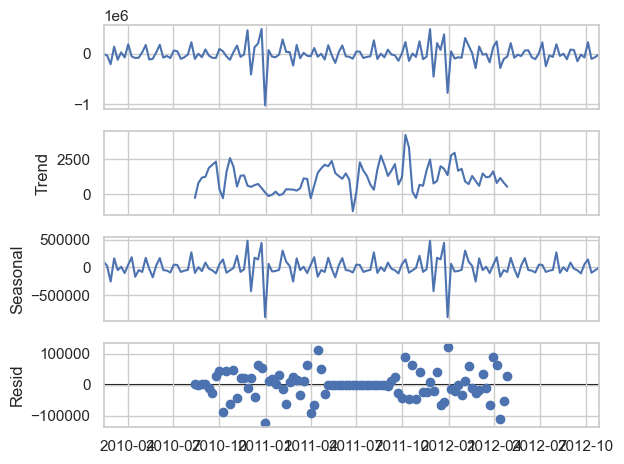

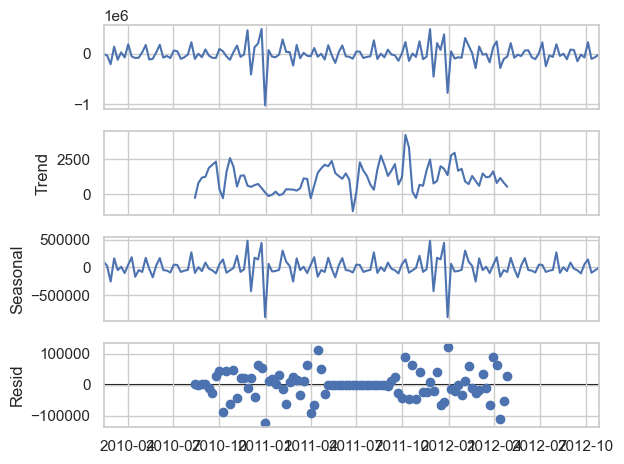

In [29]:
## again checking trend
seasonal_decomp(stationary_store1)

In [32]:
adf_test(stationary_store1)

['Test_Statistic : -7.261575374002518',
 'P_value : 1.6761796699229722e-10',
 '#Lags : 7',
 '#Observations : 134',
 "Critical Value : {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}",
 'AIC : 3396.8250847356326']

- ***Now the statistical and visual components shows enough evidance that the data is now stationary***
- ***With differencial order (d) = 1, data get stationary***

### Forcasting Model Building

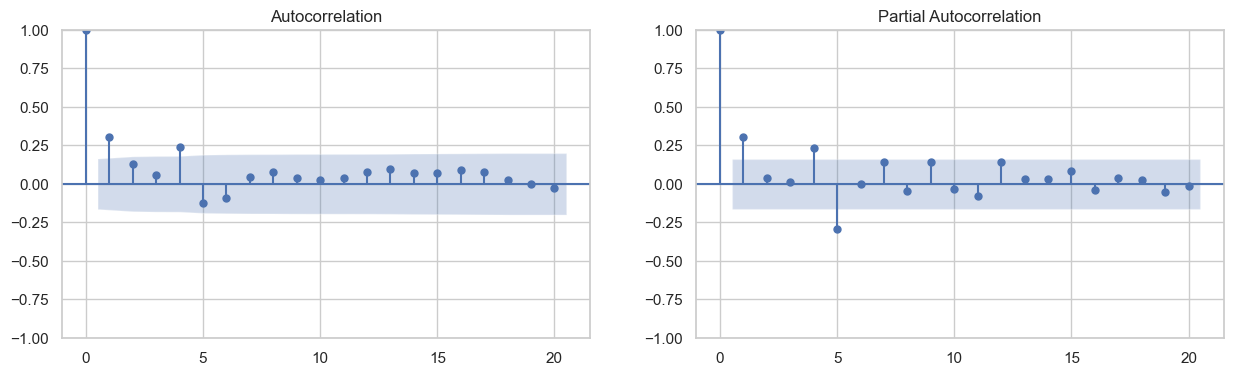

In [33]:
## Checking for Autoregressive (p) and Moving average (q) orders

acf_pacf(store1)

- ***Significant drop after Lag1 in both ACF and PACF plot shows AR and MA order as 1.***
- ***Building models with p = 1 and q = 1***

In [71]:
train = store1.iloc[:111]
test = store1.iloc[111:]

In [72]:
## ARIMA 
model_arima = ARIMA(train, order=(1,1,1))
model_arima = model_arima.fit()
y_pred = model_arima.predict(start=len(train), end=len(train)+len(test)-1, dydynamic=True)

print(f"MAE : {mean_absolute_error(test,y_pred)}")
print(f"MSE : {mean_squared_error(test,y_pred)}")
print(f"RMSE : {mean_squared_error(test,y_pred, squared=False)}")

MAE : 86442.11864122543
MSE : 11555901493.432095
RMSE : 107498.37902699786


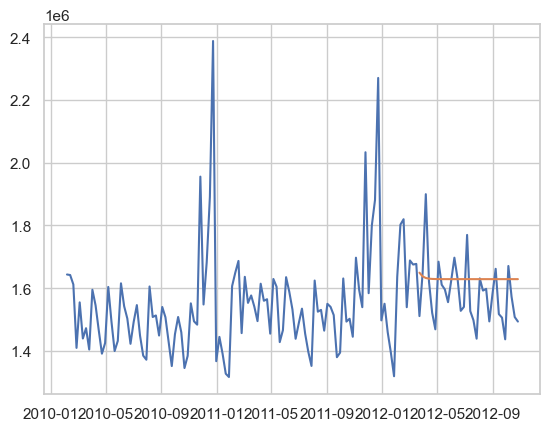

In [74]:
plt.plot(store1)
plt.plot(y_pred)

MAE : 61177.26194955774
MSE : 6932192356.289457
RMSE : 83259.78835121704


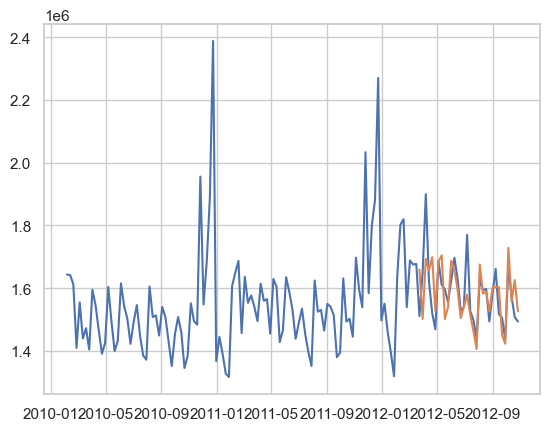

In [76]:
### Using SARIMAX Model
model_sarimax = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52), enforce_invertibility=False, enforce_stationarity=False)
model_sarimax = model_sarimax.fit()
y_pred_sarimax_1 = model_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

print(f"MAE : {mean_absolute_error(test,y_pred_sarimax_1)}")
print(f"MSE : {mean_squared_error(test,y_pred_sarimax_1)}")
print(f"RMSE : {mean_squared_error(test,y_pred_sarimax_1, squared=False)}")

plt.plot(store1)
plt.plot(y_pred_sarimax_1)

In [56]:
### using prophet model

df_store1 = store1.copy().reset_index()
df_store1.columns=["ds","y"]

train = df_store1.iloc[ : 111]
test = df_store1.iloc[111 : ]

In [58]:
model_prophet = Prophet()
model_prophet.fit(train)

future = test[["ds"]].copy()
forecast = model_prophet.predict(future)

11:18:39 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
print(f"MAE : {mean_absolute_error(test['y'],forecast.yhat)}")
print(f"MSE : {mean_squared_error(test['y'],forecast.yhat)}")
print(f"RMSE : {mean_squared_error(test['y'],forecast.yhat, squared=False)}")

MAE : 64857.55014496929
MSE : 8417412795.553421
RMSE : 91746.45930799413


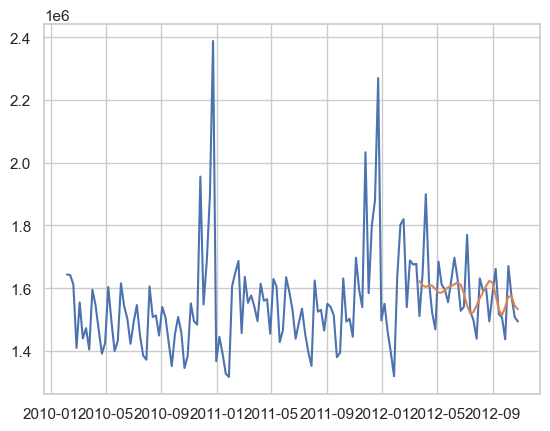

In [67]:
plt.plot(df_store1['ds'],df_store1['y'])
plt.plot(forecast.ds,forecast.yhat)

- ***From the above statistial and visual evidance suggest that SARIMAX model is performing well***
- ***Therefore using SARIMAX model for further weekly sales forecasting***

In [87]:
## Function for SARIMAX model forecast 

def forecast_weeklySales(data):
    model_sarimax = SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,52), enforce_invertibility=False, enforce_stationarity=False)
    model_sarimax = model_sarimax.fit()
    forecast = model_sarimax.forecast(steps=40)
    
    ## visualization
    plt.plot(data.index,data,color='blue',label='Original Data')
    plt.plot(forecast.index,forecast,color='orange',linestyle='--',label='Forecast Sales')
    plt.title('Forcasting Weekly Sales')
    plt.xlabel("Weeks")
    plt.ylabel("Weekly Sales")
    plt.legend(loc="best")
    plt.show()
    return forecast

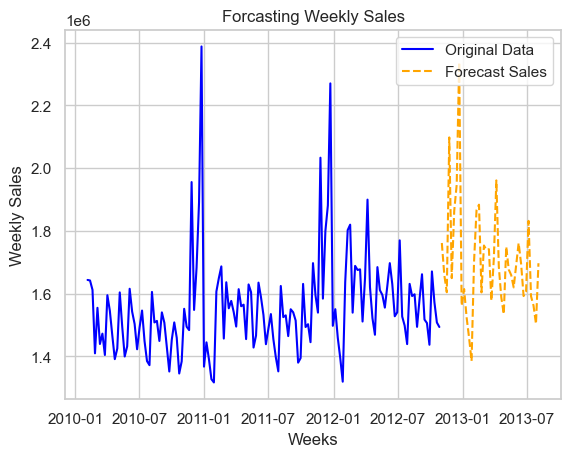

In [88]:
store1_forecast = forecast_weeklySales(store1)

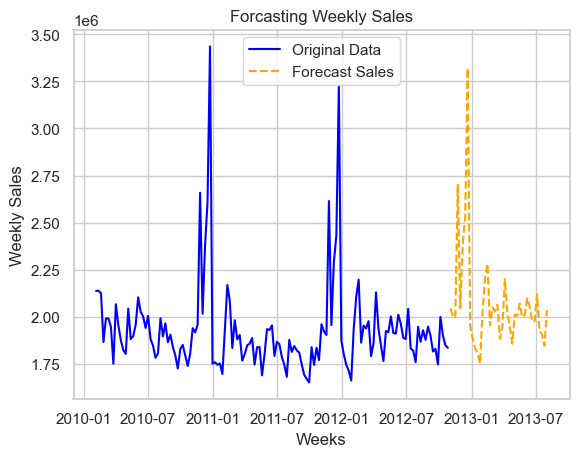

In [93]:
store2_forecast = forecast_weeklySales(store2)

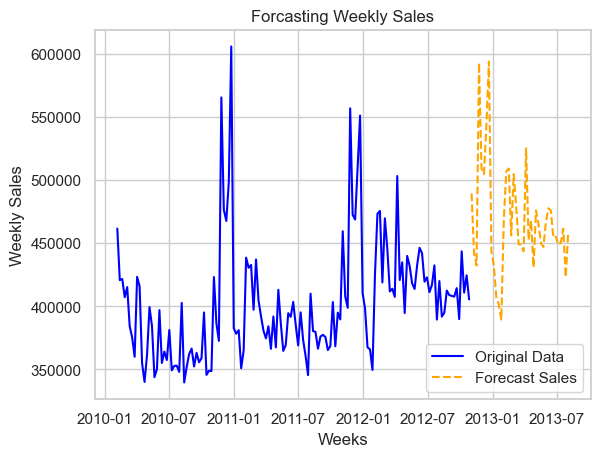

In [94]:
store3_forecast = forecast_weeklySales(store3)

In [95]:
store3_forecast

2012-11-02    489465.390184
2012-11-09    441811.939587
2012-11-16    432344.379491
2012-11-23    593050.083425
2012-11-30    509237.453394
2012-12-07    504804.619516
2012-12-14    544444.509306
2012-12-21    594017.125578
2012-12-28    443502.005502
2013-01-04    432418.612053
2013-01-11    406963.397407
2013-01-18    401175.135007
2013-01-25    389456.488629
2013-02-01    468085.273998
2013-02-08    506925.553934
2013-02-15    509191.690886
2013-02-22    456252.757036
2013-03-01    504817.534368
2013-03-08    479050.409179
2013-03-15    449058.493536
2013-03-22    448976.475189
2013-03-29    443581.219982
2013-04-05    525250.083723
2013-04-12    452590.283327
2013-04-19    467872.075593
2013-04-26    430863.963299
2013-05-03    476041.266936
2013-05-10    465301.720444
2013-05-17    449940.403336
2013-05-24    447011.080529
2013-05-31    466899.486950
2013-06-07    477710.708730
2013-06-14    475964.666262
2013-06-21    454318.797797
2013-06-28    455163.008840
2013-07-05    448636

In [2]:
((107498.37902699786 - 83259.78835121704)/107498.37902699786)*100

22.547866205213555